In [1]:
import json

In [2]:
# Carregando dados das conecões entre as cidades de Sâo Paulo
with open('dados/conexoes.json', 'r') as file:
    raw_data = file.readlines()[0]

PATHS = json.loads(raw_data)
i = 0
for key in PATHS.keys():
    if (i>=10): break
    print(f"Cidade {key} vai para {PATHS[key]}")
    i+=1

In [3]:
# De Boituva, consigo ir de ônibus para as seguintes cidades:
PATHS['boituva-sp-br']

['tatui-sp-br',
 'sorocaba-sp-br',
 'sao-paulo-sp-br',
 'salto-sp-br',
 'porto-feliz-sp-br',
 'itu-sp-br',
 'itatinga-sp-br',
 'itarare-sp-br',
 'itapeva-sp-br',
 'itapetininga-sp-br',
 'indaiatuba-sp-br',
 'capao-bonito-sp-br',
 'campinas-sp-br',
 'tatui-sp-br',
 'sorocaba-sp-br',
 'sao-paulo-sp-br',
 'salto-sp-br',
 'presidente-prudente-sp-br',
 'porto-feliz-sp-br',
 'itu-sp-br',
 'itatinga-sp-br',
 'itapeva-sp-br',
 'itapetininga-sp-br',
 'itarare-sp-br',
 'indaiatuba-sp-br',
 'capao-bonito-sp-br',
 'campinas-sp-br',
 'avare-sp-br',
 'avare-sp-br']

Note que **não há** uma conexão direta entre Boituva em São Carlos.

# Parte 1 - Busca não informada

## Busca em largura

In [4]:
def buscaLargura(ini, fim):
    visto = []
    fila = [[ini]]
 
    # Caso início = fim
    if ini == fim:
        return ini
 
    # Checando todos os caminhos
    while fila:
        caminho = fila.pop(0)
        node = caminho[-1]
        if node not in visto:
            vizinhos = PATHS[node]
            for vizinho in vizinhos:
                novo_caminho = list(caminho)
                novo_caminho.append(vizinho)
                fila.append(novo_caminho)

                # Objetivo encontrado!
                if vizinho == fim:
                    return novo_caminho
 
            # Nó já visto
            visto.append(node)
    return "Caminho não encontrado"

In [5]:
# Não é o melhor caminho porque só leva em conta número de conexões não distância 
caminho_busca_largura = buscaLargura('boituva-sp-br', 'sao-carlos-sp-br')
print(caminho_busca_largura)

['boituva-sp-br', 'sao-paulo-sp-br', 'sao-carlos-sp-br']


# Parte 2 - Busca informada

## Busca $A^*$

Para encontrarmos o melhor caminho de ônibus entre duas cidades não levamos em conta apenas o número de pontes que devemos fazer, mas também a distância entre elas! Por exemplo, embora eu possa ir de Boituva para São Carlos passando por São Paulo, esse definitivamente não é o melhor caminho.

Vamos implementar agora uma heurística definida atravéz das coordenadas geográficas de cada cidade.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from unicodedata import normalize
import seaborn as sns
sns.set()

In [7]:
# Funções para tratamento dos dados

# Remove os acentos de uma string
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

# Converte uma string de coordenada geográfica em float
def convert_coords(coordstr):
    coordstr = coordstr.replace("°", "")
    coordstr = coordstr.replace("'", "")
    
    deg, minutes, seconds = [float(i) for i in coordstr.split(' ')]
    if(deg < 0):
        return (float(deg) - float(minutes)/60 - float(seconds)/(60*60))
    else :
        return (float(deg) + float(minutes)/60 + float(seconds)/(60*60))

In [8]:
# Carregando dados da latitude e longitude e formatando nomes

dados = np.loadtxt("dados/latlon.dat", delimiter='\t', dtype=str)
coords = pd.DataFrame(dados, columns = ['nomes','lat', 'lon'])
pontos = []
for entrada in dados:
    pontos.append([convert_coords(entrada[1]), convert_coords(entrada[2])])
pontos = np.array(pontos)
coords.lat = pontos[:,0]
coords.lon = pontos[:,1]
coords.nomes = ["{}-sp-br".format(remover_acentos(nome).lower()).replace('_', '-') for nome in coords.nomes]

In [9]:
# Podemos ver as coordenadas de cada cidade
coords.query('nomes == "sao-carlos-sp-br"')

,nomes,lat,lon
504,sao-carlos-sp-br,-22.0175,-47.890833


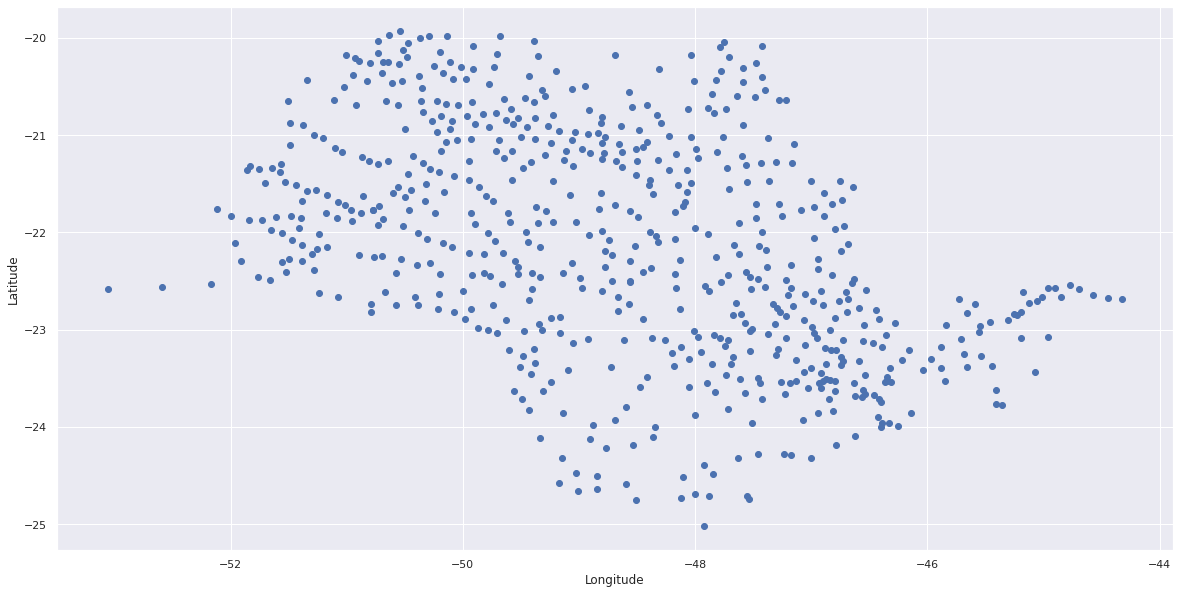

In [10]:
# E inclusive visualizá-las gráficamente
plt.figure(figsize=(20,10))
plt.scatter(coords.lon, coords.lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [11]:
# Convertendo os dados em um dicionário
arr_coords = [[nome, x, y] for nome, x, y in zip(list(coords.nomes), list(coords.lon), list(coords.lat))]
COORDS = {}
for coord in arr_coords:
    COORDS[coord[0]] = [coord[1], coord[2]]

for i in range(10):
    print(f"{list(COORDS.keys())[i]}: {list(COORDS.values())[i]}")

altair-sp-br: [-49.05888888888889, -20.52361111111111]
aguai-sp-br: [-46.978611111111114, -22.059444444444445]
alfredo-marcondes-sp-br: [-51.41277777777778, -21.955277777777777]
agudos-sp-br: [-48.987500000000004, -22.469166666666666]
aguas-da-prata-sp-br: [-46.71666666666667, -21.936666666666667]
aguas-de-sao-pedro-sp-br: [-47.876111111111115, -22.599444444444444]
aguas-de-lindoia-sp-br: [-46.632777777777775, -22.476388888888888]
alambari-sp-br: [-47.89861111111111, -23.550833333333333]
aguas-de-santa-barbara-sp-br: [-49.23888888888889, -22.880555555555556]
adolfo-sp-br: [-49.64361111111111, -21.235]


In [12]:
# Removendo do nosso grafo original os elementos que não sabemos as coordenadas

# Aplicando uma máscara aos vértices com as cidades que temos as coordenadas
mask = [not np.isin(cidade, list(COORDS.keys())).all() for cidade in PATHS.keys()]
cidades_sem_coods = np.array(list(PATHS.keys()))[mask]
print(f"Sem coordenadas de: {cidades_sem_coods}")

# Removendo chaves do dicionário de caminhos
def removeChave(d, key):
    r = dict(d)
    del r[key]
    return r


aux = {}
for key in PATHS.keys():
    aux[key] = []
    for cidade in PATHS[key]:
        if (cidade not in cidades_sem_coods):
            aux[key].append(cidade)

PATHS = aux

for i in cidades_sem_coods:
    PATHS = removeChave(PATHS, i)

Sem coordenadas de: ['mogi-das-cruzes-sp-br' 'sao-luiz-do-paraitinga-sp-br' 'ipaussu-sp-br'
 'mogi-mirim-sp-br']


In [13]:
# Distância euclidiana entre duas cidades
def distancia(a, b):
    return np.linalg.norm(np.array(COORDS[a]) - np.array(COORDS[b]))

# Cálculo do curso de determinado caminho
def calcCusto(caminho, fim):

    # calculo do custo de chegada até a última cidade do caminho
    custo_chegada = 0
    for i in range(len(caminho)-1):
        custo_chegada += distancia(caminho[i], caminho[i+1])
  
    # valor heurístico: distância euclidiana entre a última cidade do caminho e o objetivo 
    val_heuristico = distancia(caminho[-1], fim)

    custo = custo_chegada + val_heuristico
    return custo

In [14]:
# Agora, aplicando a busca A*
def buscaAStar(ini, fim):
    visto = []
    fila = [[ini]]
 
    # Caso início = fim
    if ini == fim:
        return ini
 
    # Checando todos os caminhos
    while fila:
        # Calculando custo de cada caminho na fila
        custos = [calcCusto(caminho, fim) for caminho in fila]
        idx_ordenados = np.argsort(custos)
        fila = list(np.array(fila)[idx_ordenados])

        caminho = fila.pop(0)
        node = caminho[-1]
        if node not in visto:
            vizinhos = PATHS[node]
            for vizinho in vizinhos:
                novo_caminho = list(caminho)
                novo_caminho.append(vizinho)
                fila.append(novo_caminho)

                # Objetivo encontrado!
                if vizinho == fim:
                    return novo_caminho

            # Nó já visto
            visto.append(node)
    return "Caminho não encontrado"

In [15]:
caminho_busca_informada = buscaAStar('boituva-sp-br', 'sao-carlos-sp-br')
print(caminho_busca_informada)

['boituva-sp-br', 'porto-feliz-sp-br', 'capivari-sp-br', 'piracicaba-sp-br', 'sao-carlos-sp-br']


In [16]:
# Temos que fazer ponte por muito mais cidades, mas vamos comparar a distância total percorrida

#Calculo da distância total percorrida em um caminho
def distanciaTotal(caminho):
    # calculo do custo de chegada até a última cidade do caminho
    d = 0
    for i in range(len(caminho)-1):
        d += distancia(caminho[i], caminho[i+1])
    # Convertendo distância em km (deg p/ rad * raio da Terra)
    d /= 180
    d *= 6371*np.pi
    return d


print(f"Distância percorrida na busca em largura: {round(distanciaTotal(caminho_busca_largura),2)}km")
print(f"Distância percorrida na busca A*: {round(distanciaTotal(caminho_busca_informada),2)}km")

Distância percorrida na busca em largura: 338.92km
Distância percorrida na busca A*: 159.7km


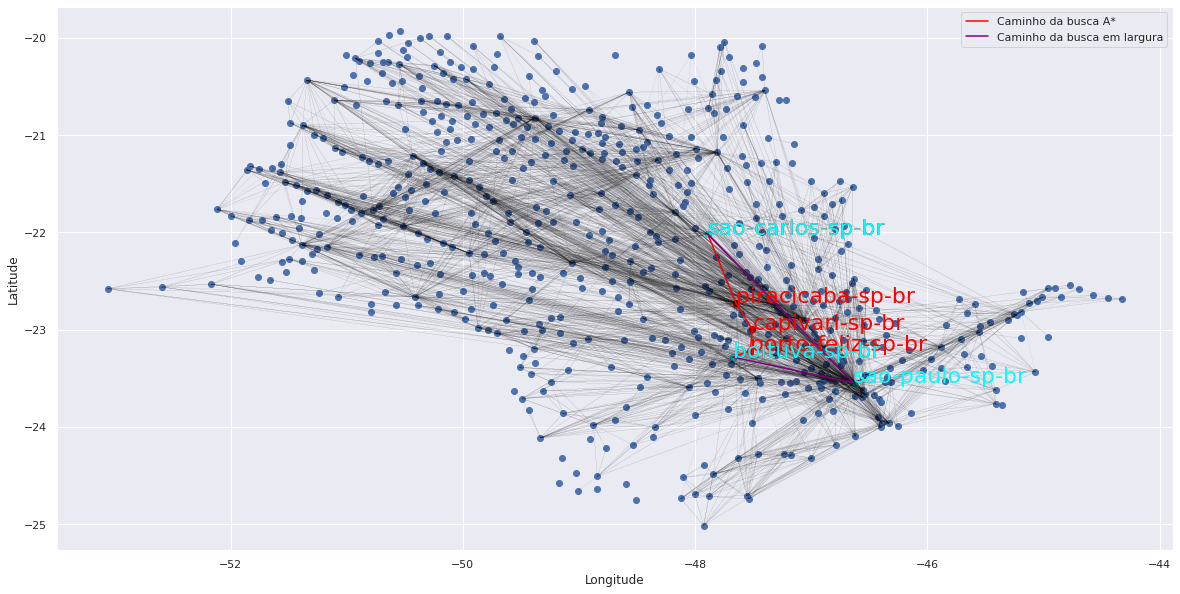

In [22]:
# Podemos visualizar o caminho no mapa

plt.figure(figsize=(20,10))

# Scatterplot das cidades
plt.scatter(coords.lon, coords.lat)

# Plot das arestas do grafo
for cidade in PATHS.keys():
    arestas = PATHS[cidade]
    for destino in arestas:
        plt.plot([COORDS[cidade][0], COORDS[destino][0]], 
                 [COORDS[cidade][1], COORDS[destino][1]], color='k', linewidth=0.02)

# Desenhando caminho tomado pela busca informada
lines = []
for i in range(len(caminho_busca_informada)):
    lines.append(COORDS[caminho_busca_informada[i]])
    plt.scatter(*COORDS[caminho_busca_informada[i]], color='red')
    plt.text(*COORDS[caminho_busca_informada[i]], caminho_busca_informada[i], color='red', fontsize=22)
lines = np.array(lines)
plt.plot(lines[:,0], lines[:,1], color='red', label='Caminho da busca A*')


# Desenhando caminho tomado pela busca não informada
lines = []
for i in range(len(caminho_busca_largura)):
    lines.append(COORDS[caminho_busca_largura[i]])
    plt.scatter(*COORDS[caminho_busca_largura[i]], color='cyan')
    plt.text(*COORDS[caminho_busca_largura[i]], caminho_busca_largura[i], color='cyan', fontsize=22)
lines = np.array(lines)
plt.plot(lines[:,0], lines[:,1], color='purple', label='Caminho da busca em largura')


plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()